### Random Forest

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os

# PATH = "/Users/luanagiusto/TP-1-ML"  # Cambia esto si tu path es diferente
PATH = "C:/Users/julia/OneDrive/Escritorio/Archivos/Capacitación/Maestría/03. Machine Learning/TP"

In [39]:
def fit_transform_rf(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        n_jobs=-1, 
        random_state=42
    )

    rf.fit(X_train, y_train)

    proba = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)
    return rf, auc, proba

In [40]:

def plot_feature_importance(rf, X, top_k=20):
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top = imp.head(top_k)[::-1]  # invertir para barh ascendente

    plt.figure(figsize=(8, max(4, top_k*0.4)))
    top.plot(kind="barh")
    plt.title(f"Importancias (Random Forest) - Top {top_k}")
    plt.xlabel("Gini importance")
    plt.tight_layout()
    plt.show()

    return imp


In [41]:
# Cargar datos
df = pd.read_parquet(os.path.join(PATH, 'train_df.parquet'))

# Separar features y target
xs = df.drop(columns='target')
y = df['target']

# Entrenar y evaluar
rf, auc, proba = fit_transform_rf(xs, y)
print(f"ROC-AUC (validación): {auc:.6f}")

ROC-AUC (validación): 0.750393


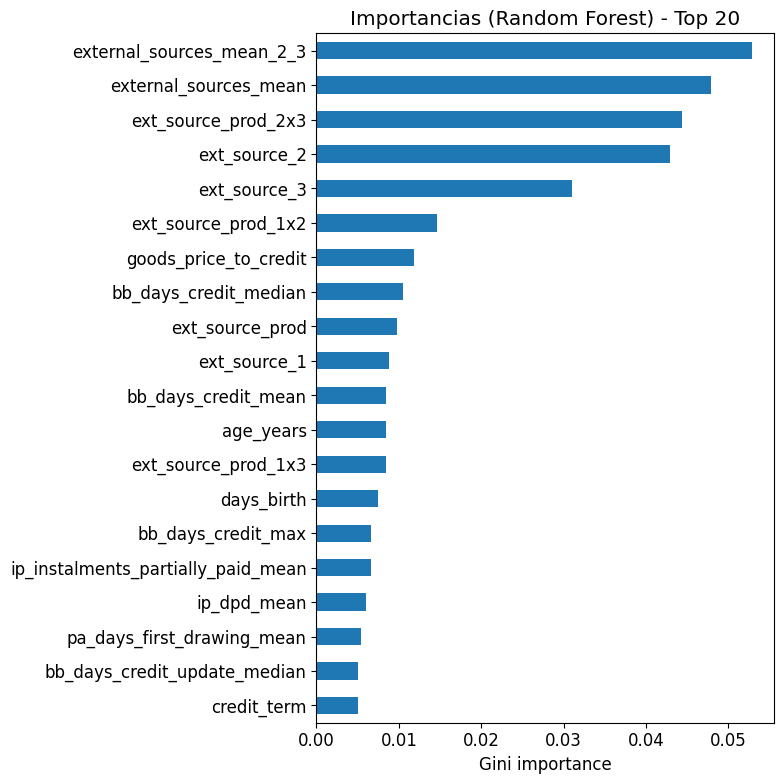

In [42]:
# Calcular y graficar importancias de features
imp = plot_feature_importance(rf, xs, top_k=20)


In [ ]:
# Probamos quedarnos con solo features por arriba del threshold de importancia de features
imp = pd.Series(rf.feature_importances_, index=xs.columns).sort_values(ascending=False) # Importancias

# Filtrar features con importancia > threshold
threshold = 0.006
selected_features = imp[imp > threshold].index
X_reduced = xs[selected_features]

print(f"Total features: {xs.shape[1]}")
print(f"Features retenidas (> {threshold*100:.2f}%): {X_reduced.shape[1]}")
print(f"Features descartadas: {xs.shape[1] - X_reduced.shape[1]}")

# Reentrenar con features reducidas
rf_reduced, auc_reduced, proba_reduced = fit_transform_rf(X_reduced, y)
print(f"ROC-AUC (validación, reduced set): {auc_reduced:.6f}")


Total features: 846
Features retenidas (> 0.50%): 19
Features descartadas: 827
ROC-AUC (validación, reduced set): 0.743462


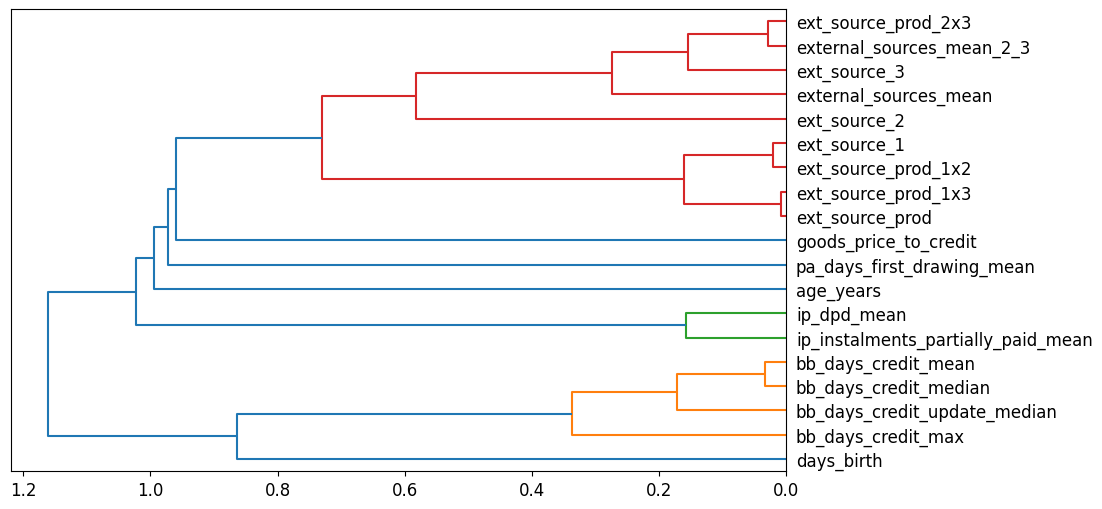

In [44]:
# Estudio de las columnas de a pares para ir viendo cuales "se parecen" en la información que entregan usando fastai 
# haciendo clustering jerarquico de las columnas que las va agrupando según lo parecidas que son.

cluster_columns(X_reduced)

In [45]:
# Para ver cuales columnas tiramos vamos a proponer como candidatos a los grupos de columnas que se formaron en el gráfico anterior y 
# calcular el oob score al sacar cada columna por separado.
def get_oob(df):
    m = RandomForestRegressor(n_estimators=100, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [46]:
get_oob(X_reduced)

0.073182106300972

In [47]:
# Partial Dependence: ver cómo las dos variables que resultaron más importantes afectan en la predicción.
top2_features = imp.head(2).index.tolist()
print("Top 2 features:", top2_features)

Top 2 features: ['external_sources_mean_2_3', 'external_sources_mean']


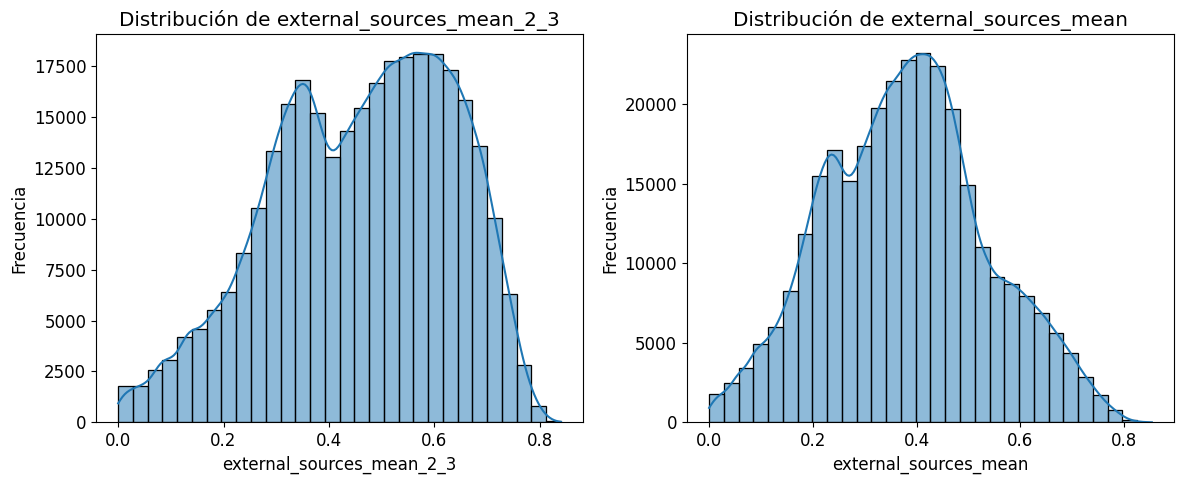

In [48]:
# Veamos primero las distribuciones de estas dos columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, feat in enumerate(top2_features):
    sns.histplot(xs[feat], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


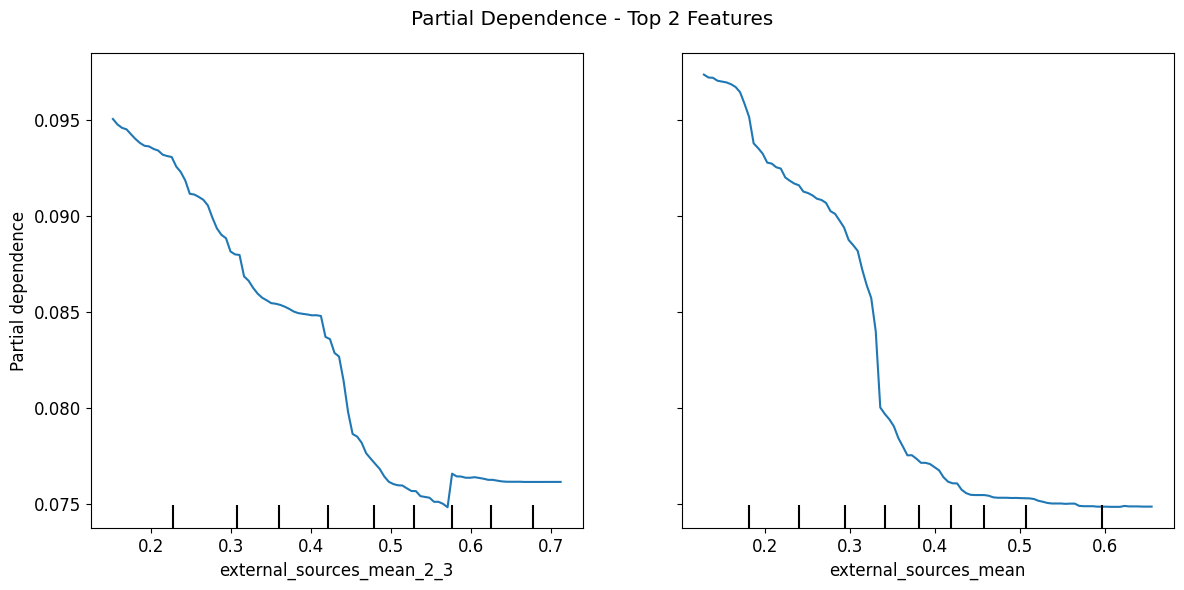

In [49]:
# Gráfico conjunto de las 2 features más importantes
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf, xs, top2_features, ax=ax
)
plt.suptitle("Partial Dependence - Top 2 Features")
plt.tight_layout()
plt.show()

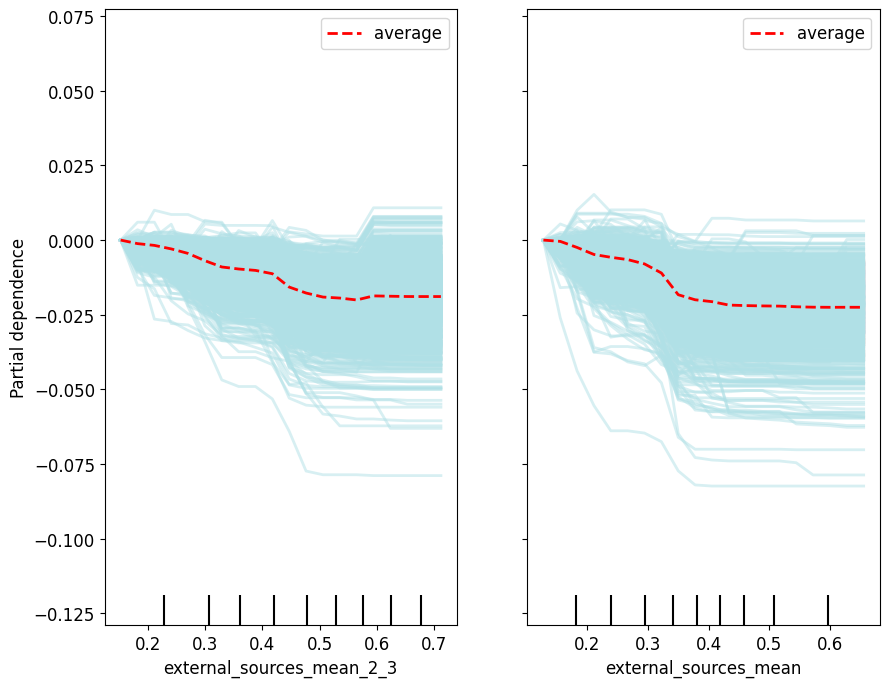

In [50]:
# Gráfico Individual conditional expectation. 
# Este gráfico es análogo al PDP pero no toma el valor promedio si no que muestra la predicción de todas las filas.
fig, ax = plt.subplots(figsize=(10, 8))

common_params = {"grid_resolution": 20, "random_state": 0}
features_info = {"features": top2_features, "kind": "both", "centered": True}
display = PartialDependenceDisplay.from_estimator(
    rf,
    xs,
    **features_info,
    ax=ax,
    line_kw={"color": "red", "linewidth": 2},
    ice_lines_kw={"color": "#B0E0E6", "alpha": 0.5},
    **common_params,
)
